# Python implementation of Logistic Regression from scratch

_Umberto Michelucci, um@udata.science_

### Abstract

In this notebook I develop a complete version of Logistic Regression from scratch, without using any library (except numpy). I apply the model to a subset of MNIST data containing only the digits 1 and 2 (see the data preparation part to see how to do it) to do binary classification. For the equations and the mathematics behind the python code you can refer (to this notebook)[http://localhost:8888/notebooks/Documents/Data%20Science/Projects/Logistic-Regression-Explained/Logistic%20Regression%20from%20scratch.ipynb#] where I did a complete derivation of the mathematics behind the model. The relevant equations are reported here to make it easier for the reader to follow the code.

**NOTE**: the formulas are not explained or derived and are reported only to help the reader follow the Python code. For a derivation and justification please refer to the notebook above.

## Libraries

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Data preparation

To get MNIST data we use the function fetch_mldata, in the datasets package. Let's get all the dataset, and then we will select only the digits we want.

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X,y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

To know how many digits we have we can run this simple code

In [6]:
total = 0
for i in range(10):
    print ("digit", i, "appear", np.count_nonzero(y == i), "times")

digit 0 appear 6903 times
digit 1 appear 7877 times
digit 2 appear 6990 times
digit 3 appear 7141 times
digit 4 appear 6824 times
digit 5 appear 6313 times
digit 6 appear 6876 times
digit 7 appear 7293 times
digit 8 appear 6825 times
digit 9 appear 6958 times


Note: datasets loaded by scikit-learn have a dictionary structure. 

- a DESCR structure describing the dataset
- a ```data``` key containing an array with one row per instance and one column per feature
- a ```target``` with an array with the labels

we have 70000 digits available, from 0 to 9. Let's define a helper function that will allow us to visualize the digits.

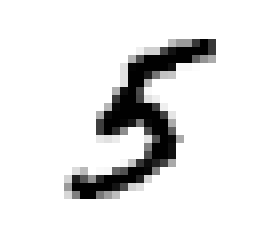

In [7]:
def plot_digit(some_digit):
    
    some_digit_image = some_digit.reshape(28,28)

    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()
    
plot_digit(X[36003])

Let's check the relative label...

In [8]:
y[36003]

5.0

### Train and test set preparation

Let's first reduce our dataset only to 1 and 2 digits.

In [9]:
X_12 = X[np.any([y == 1,y == 2], axis = 0)]
y_12 = y[np.any([y == 1,y == 2], axis = 0)]

Let's check a couple of digits

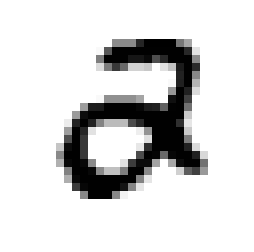

2.0


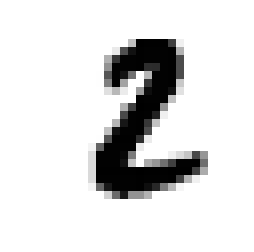

2.0


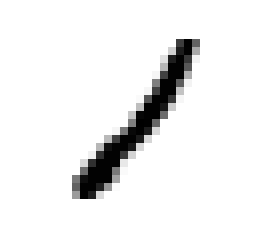

1.0


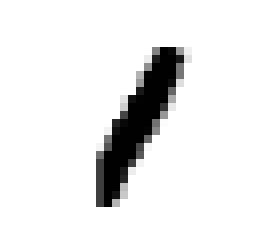

1.0


In [10]:
plot_digit(X_12[8000])
print(y_12[8000])

plot_digit(X_12[9345])
print(y_12[9345])

plot_digit(X_12[877])
print(y_12[877])

plot_digit(X_12[144])
print(y_12[144])

The size of our dataset is

In [11]:
print(X_12.shape)
print(y_12.shape)

(14867, 784)
(14867,)


In our reduced dataset how many 1 and 2 do we have?

In [12]:
print("number of 1:", np.count_nonzero(y_12 == 1))
print("number of 2:", np.count_nonzero(y_12 == 2))

number of 1: 7877
number of 2: 6990


Let's shuffle the elements and create a train and a test set. Altough it would be useful we will not do here a stratified sampling, prefering a simpler solution since the main point of this notebook is the complete implementation of logistic regression from scratch.

In [13]:
shuffle_index = np.random.permutation(X_12.shape[0])
X_12_shuffled, y_12_shuffled = X_12[shuffle_index], y_12[shuffle_index]

train_proportion = 0.8
train_test_cut = int(len(X_12)*train_proportion)

X_train, X_test, y_train, y_test = \
    X_12_shuffled[:train_test_cut], \
    X_12_shuffled[train_test_cut:], \
    y_12_shuffled[:train_test_cut], \
    y_12_shuffled[train_test_cut:]
    
print("Shape of X_train is", X_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of y_test is", y_test.shape)

Shape of X_train is (11893, 784)
Shape of X_test is (2974, 784)
Shape of y_train is (11893,)
Shape of y_test is (2974,)


Let's check the proportions of 1 and 2 in our training and test set. In our original set we had the proportion of

In [14]:
np.count_nonzero(y_12 == 1) / np.count_nonzero(y_12 == 2)

1.12689556509299

In our training and test set we have the proportions

In [15]:
print(np.count_nonzero(y_train == 1) / np.count_nonzero(y_train == 2))
print(np.count_nonzero(y_test == 1) / np.count_nonzero(y_test == 2))

1.1139353003910415
1.1803519061583578


So we are pretty close to the same proportion in our original dataset. Note that in this case is not so importnat since our training set is not so skewed, but normally you would have to do a stratified sampling.

## Normalisation

Let's normalise our data. The pixel will have a value between 0 and 255 (gray values). Let's normalise the value between 0 and 1.

In [16]:
X_train_normalised = X_train/255.0
X_test_normalised = X_test/255.0

Remember that we need features along the rows, and training cases along the columns. So let's reshape our dataset

In [17]:
X_train_tr = X_train_normalised.transpose()
y_train_tr = y_train.reshape(1,y_train.shape[0])
X_test_tr = X_test_normalised.transpose()
y_test_tr = y_test.reshape(1,y_test.shape[0])

print(X_train_tr.shape)
print(y_train_tr.shape)
print(X_test_tr.shape)
print(y_test_tr.shape)

dim_train = X_train_tr.shape[1]
dim_test = X_test_tr.shape[1]

print("The training dataset has dimensions equal to", dim_train)
print("The test set has dimensions equal to", dim_test)

(784, 11893)
(1, 11893)
(784, 2974)
(1, 2974)
The training dataset has dimensions equal to 11893
The test set has dimensions equal to 2974


We will need to rescale our lables. Remember we will compare them in the cost function with 0 and 1 (proabilities) and therefore our class labels must be 0 and 1, not 1 and 2. So the following step take care of it.

In [20]:
y_train_shifted = y_train_tr - 1
y_test_shifted = y_test_tr - 1

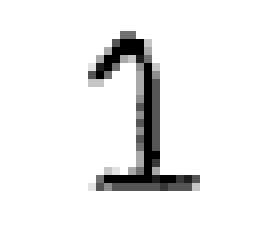

[ 0.]


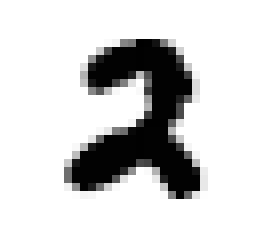

[ 1.]


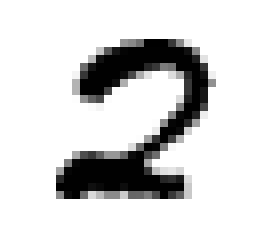

[ 1.]


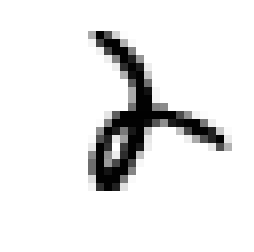

[ 1.]


In [32]:
plot_digit(X_train_tr[:,1005])
print(y_train_shifted[:,1005])
plot_digit(X_train_tr[:,1432])
print(y_train_shifted[:,1432])
plot_digit(X_train_tr[:,456])
print(y_train_shifted[:,456])
plot_digit(X_train_tr[:,567])
print(y_train_shifted[:,567])

Xtrain = X_train_tr
ytrain = y_train_shifted
Xtest = X_test_tr
ytest = y_test_shifted

## Helper functions

Now we will define a few helper function that we will put together to build a ```model()``` function that will train our model and give as a result a dictionary with the result. Where relevant we will put the mathematical formula we have used. As a reference you can check [this notebook on github](https://github.com/michelucci/Logistic-Regression-Explained/blob/master/Logistic%20Regression%20from%20scratch.ipynb) where I did a complete mathematical derivation of the necessary equation.

### Sigmoid function

This function will calculate the following formula given an input $z$

$$ \displaystyle
\sigma(z) = \frac{1}{1+e^{-z}}
\tag{1}
$$

In [25]:
def sigmoid(z):
    """
    Implement the sigmoid function

    Arguments:
    y -- a scalar (float)

    Return:
    s -- the sigmoid function evaluated on z (as in equation (1))
    """
    s = 1.0 / (1.0 + np.exp(-z))
    
    return s

In [26]:
def initialize(dim):
    """
    Initialise the weights and the bias to tensors of dimensions (dim,1) for w and
    to 1 for b (a scalar)

    Arguments:
    dim -- a scalar (float)

    Return:
    w -- a matrix of dimensions (dim,1) containing all zero
    b -- a scalar = 0
    """
    w = np.zeros((dim,1))
    b = 0
    
    assert (w.shape == (dim,1))
    assert (isinstance(b, float) or isinstance(b,int))
    
    return w,b

The following function ```propagate(w,b,X,Y)``` will calculate 

$$
\displaystyle
\frac{\partial \mathscr{L} (a,y)}{\partial w_j} = \frac{1}{m} X (A-Y)^T
\tag{2}
$$

$$
\displaystyle
\frac{\partial \mathscr{L} (a,y)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m}(A_i-Y_i) 
\tag{3}
$$
and
$$
\displaystyle
J(w,b) = \frac{1}{m} \sum_{i=1}^{m} \mathscr{L} (a^{(i)},y^{(i)})
\tag{4}
$$

given
$$
\mathscr{L} (a,y) = -\left[ y \log a + (1-y) \log (1-a) \right]
\tag{5}
$$

Our inputs are the weight $w \in \mathbb{R}^{n_x \times 1}$ ($n_x$ number of features), $b \in \mathbb{R}$, $X \in \mathbb{R}^{n_x \times m}$, $Y \in \mathbb{R}^{1 \times m}$, $m$ is the number of training cases we have.

In [27]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px, 1) (our case 784,1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px, number of examples)
    Y -- true "label" vector (containing 0 if class 1, 1 if class 2) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    z = np.dot(w.T,X)+b
    A = sigmoid(z)
    cost = -1.0/m*np.sum(Y*np.log(A)+(1.0-Y)*np.log(1.0-A))
    
    dw = 1.0/m*np.dot(X, (A-Y).T)
    db = 1.0/m*np.sum(A-Y)
    
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    
    cost = np.squeeze(cost)
    assert (cost.shape == ())
    
    grads = {"dw": dw, 
             "db":db}
    
    return grads, cost

This function actually perform the gradient descent algorithm. It does a loop modifying at each iterations the weigths and the bias according to (for an explanation of notation please refer to [this notebook](http://localhost:8888/notebooks/Documents/Data%20Science/Projects/Logistic-Regression-Explained/Logistic%20Regression%20from%20scratch.ipynb#).

$$\displaystyle
w_{[n+1]} = w_{[n]}-\alpha \frac{1}{m} X (A-Y)^T
$$

and

$$\displaystyle
b_{[n+1]} = b_{[n]}-\alpha \frac{1}{m} \sum_{i=1}^{m}(A_i-Y_i)
$$

In [28]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (n_x, 1)
    b -- bias, a scalar
    X -- data of shape (n_x, m)
    Y -- true "label" vector (containing 0 if class 1, 1 if class 2), of shape (1, m)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
            
        if print_cost and i % 100 == 0:
            print ("Cost (iteration %i) = %f" %(i, cost))
            
    grads = {"dw": dw, "db": db}
    params = {"w": w, "b": b}
        
    return params, grads, costs

The function ```predict()``` create a matrix of dimensions $(1,m)$ that contains the predictions of the model given the input $w$, $b$ and $X$. Each prediction is assigned to class 1 if $\sigma(w^T X+b) > 0.5$ and to class 2 if $\sigma(w^T X+b) \leq 0.5$

In [29]:
def predict (w, b, X):
    '''
    Predict whether the label is 0 or 1 
    
    Arguments:
    w -- weights, a numpy array of size (n_x, 1)
    b -- bias, a scalar
    X -- data of size (n_x, m)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) 
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid (np.dot(w.T, X)+b)
    
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            Y_prediction[:, i] = 1
        elif (A[:,i] <= 0.5):
            Y_prediction[:, i] = 0
            
    assert (Y_prediction.shape == (1,m))
    
    return Y_prediction
        

Now let's define the ```model()``` function that will put everything together.

In [30]:
def model (X_train, Y_train, X_test, Y_test, num_iterations = 1000, learning_rate = 0.5, print_cost = False):
    
    w, b = initialize(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict (w, b, X_test)
    Y_prediction_train = predict (w, b, X_train)
    
    train_accuracy = 100.0 - np.mean(np.abs(Y_prediction_train-Y_train)*100.0)
    test_accuracy = 100.0 - np.mean(np.abs(Y_prediction_test-Y_test)*100.0)
    
    d = {"costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    
    print ("Accuarcy Test: ",  test_accuracy)
    print ("Accuracy Train: ", train_accuracy)
    
    return d

## Test of the model

Let's test our model on our datasets containing only the digits 1 and 2.

In [33]:
d = model (Xtrain, 
           ytrain, 
           Xtest, 
           ytest, 
           num_iterations = 4000, 
           learning_rate = 0.05, 
           print_cost = True)

Cost (iteration 0) = 0.693147
Cost (iteration 100) = 0.109078
Cost (iteration 200) = 0.079466
Cost (iteration 300) = 0.067267
Cost (iteration 400) = 0.060286
Cost (iteration 500) = 0.055634
Cost (iteration 600) = 0.052246
Cost (iteration 700) = 0.049633
Cost (iteration 800) = 0.047536
Cost (iteration 900) = 0.045801
Cost (iteration 1000) = 0.044333
Cost (iteration 1100) = 0.043070
Cost (iteration 1200) = 0.041967
Cost (iteration 1300) = 0.040992
Cost (iteration 1400) = 0.040123
Cost (iteration 1500) = 0.039340
Cost (iteration 1600) = 0.038631
Cost (iteration 1700) = 0.037985
Cost (iteration 1800) = 0.037393
Cost (iteration 1900) = 0.036847
Cost (iteration 2000) = 0.036342
Cost (iteration 2100) = 0.035873
Cost (iteration 2200) = 0.035435
Cost (iteration 2300) = 0.035027
Cost (iteration 2400) = 0.034643
Cost (iteration 2500) = 0.034282
Cost (iteration 2600) = 0.033942
Cost (iteration 2700) = 0.033621
Cost (iteration 2800) = 0.033317
Cost (iteration 2900) = 0.033028
Cost (iteration 3000) 

So we get an accuracy of roughly 99%. Pretty good. 
Let's see how the confusion matrix look like. To make it easier let's use the ```confusion_matrix()``` function from the package ```sklearn.metrics```.

In [77]:
ypred = d["Y_prediction_test"]
ypred_ravel = ypred.ravel()
ytest_ravel = ytest.ravel()

from sklearn.metrics import confusion_matrix

confusion_matrix (ytest_ravel, ypred_ravel)

array([[1596,   14],
       [  13, 1351]])

Note that this works really well since 1 and 2 are easy to distinguish. If you check all the digits you will see that (for example) two of the digits that are the most difficult (relatively) to distinguish are 3 and 5. The same notebook can be run with different digits to check this.

## Cost function vs. number of iterations

Let's see how the cost function decrease with the number of iterations. We have the value of the cost function every $100$ iterations so we can easily plot it.

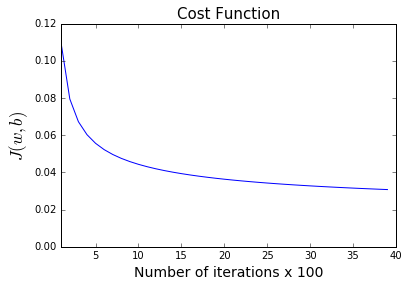

In [34]:
plt.plot(d["costs"])
plt.xlim([1,40])
plt.ylim([0,0.12])
plt.title("Cost Function",fontsize = 15)
plt.xlabel("Number of iterations x 100", fontsize = 14)
plt.ylabel("$J(w,b)$", fontsize = 17)
plt.show()

## Logistic Regression with sklearn

As a side note, here is the code to see how easy it is in comparison to do the same with the sklearn library... 

In [36]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

In [37]:
XX = Xtrain.T
YY = ytrain.T.ravel()

logistic.fit(XX,YY)

(11893, 784)
(11893,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
logistic.score(XX,YY)

0.9957958462961406

The score is calculated as 

In [78]:
sum(logistic.predict(XX) == YY) / len(XX)

0.9957958462961406